# Image Classification on small dataset

In this project, we collect image data of four buildings/objects in Shanghai and Guangzhou. Each class contains 100~150 photos of building/objects taken from different angles and distances. This notebook trains a model to recognize these classes. The notebook is initially run on the [google colab](https://colab.research.google.com). The data is stored and downloaded on the [google drive](https://drive.google.com/file/d/1rj-RaymLVMJoZOrkxa2wt0h2-EoPrDVL/view?usp=sharing). You can download the data by simply requesting access to it.

Main steps in this notebook:

I. Upload data

II. Preprocess data

    (a) split train and validation data
    (b) preprocess and generate image data batch
    
III. Recognize objects by training on a small dataset

IV. Use data augmentation to gain higher accuracy

V. Export the model and run it in the browser

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [ ]:
import IPython.display as display
import matplotlib.pyplot as plt
import random
import time
import pathlib
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
from google.colab import files

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 192
SHUFFLE_SIZE = 1000

In [ ]:
def load_and_preprocess_image(path):
    img = tf.io.read_file(path)  # read
    img = tf.image.decode_jpeg(img, channels=3)  # decode
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])  # resize
    img /= 255.0  # normalize pixels to 0,1
    return img

In [ ]:
def show(img, label):
    plt.imshow(img)
    plt.title(label)
    plt.xticks([])
    plt.yticks([])
    print()

In [ ]:
def plot(history):
  
    # The history object contains results on the training and test
    # sets for each epoch
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get the number of epochs
    epochs = range(len(acc))

    plt.title('Training and validation accuracy')
    plt.plot(epochs, acc, color='blue', label='Train')
    plt.plot(epochs, val_acc, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    _ = plt.figure()
    plt.title('Training and validation loss')
    plt.plot(epochs, loss, color='blue', label='Train')
    plt.plot(epochs, val_loss, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

## I. Upload data

In [ ]:
# The data is uploaded on the google drive: https://drive.google.com/file/d/1rj-RaymLVMJoZOrkxa2wt0h2-EoPrDVL/view?usp=sharing
# It contains four places in my neighborhood. Each of them has more than 100 pictures.
from google.colab import drive
# log in to the google drive account
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# untar the tgz file of the data into Colab. The data is stored under /content directory.
!tar -xvf  '/gdrive/MyDrive/4995HW2/objects_data.tgz'

processed/
processed/museum/
processed/pavilion/
processed/stone/
processed/theater/
processed/theater/theater (1).png
processed/theater/theater (10).png
processed/theater/theater (100).png
processed/theater/theater (101).png
processed/theater/theater (102).png
processed/theater/theater (103).png
processed/theater/theater (104).png
processed/theater/theater (105).png
processed/theater/theater (106).png
processed/theater/theater (107).png
processed/theater/theater (108).png
processed/theater/theater (109).png
processed/theater/theater (11).png
processed/theater/theater (110).png
processed/theater/theater (111).png
processed/theater/theater (112).png
processed/theater/theater (113).png
processed/theater/theater (114).png
processed/theater/theater (115).png
processed/theater/theater (116).png
processed/theater/theater (117).png
processed/theater/theater (118).png
processed/theater/theater (119).png
processed/theater/theater (12).png
processed/theater/theater (120).png
processed/theater/th

In [ ]:
# directory of class data
data_root = pathlib.Path('/content/processed')

In [ ]:
# There are four classes in the data.
list(data_root.glob('*'))

[PosixPath('/content/processed/theater'),
 PosixPath('/content/processed/stone'),
 PosixPath('/content/processed/pavilion'),
 PosixPath('/content/processed/museum')]

In [ ]:
import shutil
import os
import numpy as np

In [ ]:
all_image_paths = list(data_root.glob('*/*')) # get all file paths from the root path
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)
# Show the number of all images in the dataset
image_count = len(all_image_paths)
image_count

547

In [ ]:
# Show example of five image paths.
all_image_paths[:5]

['/content/processed/stone/stone (64).png',
 '/content/processed/museum/museum (23).png',
 '/content/processed/theater/theater (127).png',
 '/content/processed/stone/stone (127).png',
 '/content/processed/theater/theater (112).png']

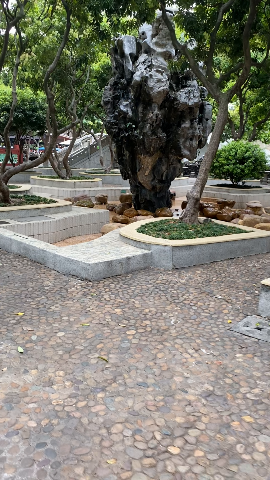

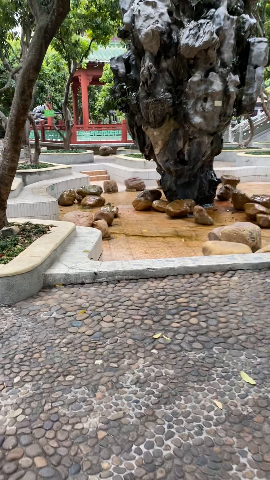

In [ ]:
# Show example of some images. The pictures is taken from different angles and distance to the object.
for n in range(2):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path))
    print()

## II. Preprocess data

### (a) split train and validation data

In [ ]:
def split_dataset_into_test_and_train_sets(all_data_dir, training_data_dir, testing_data_dir):
    # Recreate testing and training directories
    # Randomly split train and test
    if os.path.exists(testing_data_dir): # Clear the existing test directory
        shutil.rmtree(testing_data_dir, ignore_errors=False)
    if os.path.exists(training_data_dir): # Clear the existing train directory
        shutil.rmtree(training_data_dir, ignore_errors=False)
    os.makedirs(testing_data_dir)
    os.makedirs(training_data_dir)

    # record number of train and test files
    num_training_files = 0
    num_testing_files = 0

    for subdir, dirs, files in os.walk(all_data_dir):
        category_name = os.path.basename(subdir)

        # Don't create a subdirectory for the root directory
        if category_name == os.path.basename(all_data_dir):
            continue

        training_data_category_dir = pathlib.Path(str(training_data_dir) + '/' + category_name)
        testing_data_category_dir = pathlib.Path(str(testing_data_dir) + '/' + category_name)

        if not os.path.exists(training_data_category_dir):
            os.mkdir(training_data_category_dir)

        if not os.path.exists(testing_data_category_dir):
            os.mkdir(testing_data_category_dir)
        # Randomly shuffle the data in the same class and separate the shuffled data to train and test equally.
        random.shuffle(files)
        n = len(files)
        for file in files[:n//2]:
            input_file = os.path.join(subdir, file)
            # Copy the first half of the shuffled data to the test directory
            shutil.copy(input_file, pathlib.Path(str(testing_data_dir) + '/' + category_name + '/' + file))
            num_testing_files += 1
            
        for file in files[n//2:]:
            input_file = os.path.join(subdir, file)
            # Copy the second half of shuffled data to the train directory
            shutil.copy(input_file, pathlib.Path(str(training_data_dir) + '/' + category_name + '/' + file))
            num_training_files += 1
        
    print("Processed " + str(num_training_files) + " training files.")
    print("Processed " + str(num_testing_files) + " testing files.")

In [ ]:
training_data_dir = pathlib.Path('/content/training_data')
testing_data_dir = pathlib.Path('/content/testing_data')
split_dataset_into_test_and_train_sets(data_root, training_data_dir, testing_data_dir)

Processed 274 training files.
Processed 273 testing files.


### (b) preprocess and generate image data batch

In [ ]:
# Example code showing the correct imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator

label_names = ['museum', 'pavilion', 'stone', 'theater']
# Example code:
# You should use the keras preprocessing utilities here instead of tf.data
# Here's an example of how to use them with the flowers dataset
# You will need to add data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
# generate training data from training data directory
train_generator = train_datagen.flow_from_directory(
        training_data_dir,
        target_size=(IMG_SIZE, IMG_SIZE), # adjust the image to target size
        batch_size=BATCH_SIZE,
        classes=label_names) 
# generate validation data from test data directory
validation_generator = train_datagen.flow_from_directory(
    testing_data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    classes=label_names)

for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

###
# TODO: your code for 2a here.
###


Found 274 images belonging to 4 classes.
Found 273 images belonging to 4 classes.
data batch shape: (32, 192, 192, 3)
labels batch shape: (32, 4)


The training data is in the /content/training_data directory and the validation data is in the /content/testing_data directory. Here we use validation data instead of test data.

### III. Recognize objects by training on a small dataset

In [ ]:
# Create a small model as baseline.
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu',
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# The depth of the feature maps is progressively increasing in the network (from 16 to 64).
# To make the model from scratch small, we use four max pooling layer to reduce the number of parameters.
# The number of filters in the convolutional layer is at most 64 since we are only training a small model.

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(4, activation='softmax')) # Now we have four classes

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 190, 190, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 95, 95, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 93, 93, 32)        4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 44, 44, 32)        9248      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 22, 22, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 15488)            

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy', # Because our labels are one-hot encoded, we need to use categorical_crossentropy
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator, validation_data=validation_generator, epochs=20)

Epoch 1/20
9/9 [==============================] - 13s 2s/step - loss: 1.4112 - accuracy: 0.3176 - val_loss: 1.1420 - val_accuracy: 0.5458
Epoch 2/20
9/9 [==============================] - 12s 1s/step - loss: 1.0354 - accuracy: 0.6571 - val_loss: 0.6776 - val_accuracy: 0.7656
Epoch 3/20
9/9 [==============================] - 12s 1s/step - loss: 0.6736 - accuracy: 0.7522 - val_loss: 0.5004 - val_accuracy: 0.7912
Epoch 4/20
9/9 [==============================] - 12s 1s/step - loss: 0.4783 - accuracy: 0.8209 - val_loss: 0.4679 - val_accuracy: 0.8059
Epoch 5/20
9/9 [==============================] - 12s 1s/step - loss: 0.3454 - accuracy: 0.8580 - val_loss: 0.3769 - val_accuracy: 0.8425
Epoch 6/20
9/9 [==============================] - 12s 1s/step - loss: 0.2519 - accuracy: 0.9415 - val_loss: 0.2953 - val_accuracy: 0.8828
Epoch 7/20
9/9 [==============================] - 12s 1s/step - loss: 0.1766 - accuracy: 0.9377 - val_loss: 0.2321 - val_accuracy: 0.9158
Epoch 8/20
9/9 [==================

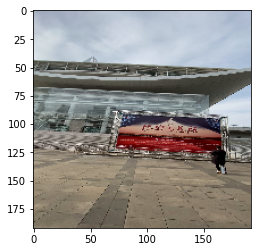

Prediction theater
Actual theater


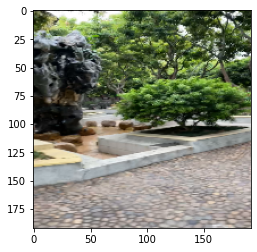

Prediction stone
Actual stone


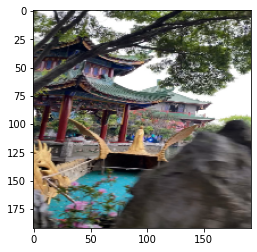

Prediction pavilion
Actual pavilion


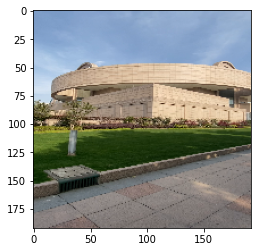

Prediction museum
Actual museum


In [ ]:
# Show one prediction for each class
for class_path in list(pathlib.Path('/content/testing_data').glob('*')):
    label = os.path.basename(class_path)
    for image_path in list(class_path.glob('*')):
        img = load_and_preprocess_image(str(image_path)) # read and preprocess the image
        batch_pred = model.predict(tf.expand_dims(img, axis=0)) # return prediction of batch size 1
        pred = batch_pred[0]
        plt.imshow(img) # plot the image
        plt.show()
        print("Prediction", label_names[tf.argmax(pred)])
        print("Actual", label)
        break

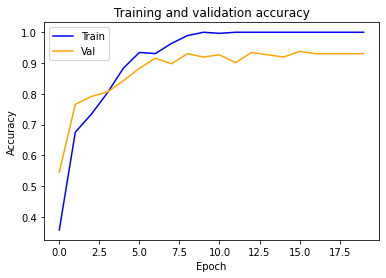

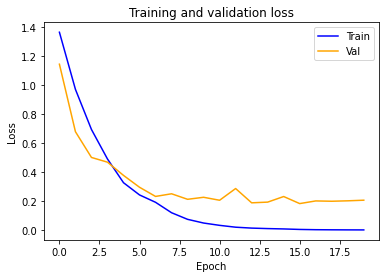

In [ ]:
plot(history)

The training converges after 6th epoch and validation accuracy does not increase after that. The validation accuracy reaches about 93%.

## IV. Use data augmentation to gain higher accuracy

Data augmentation is used to generate new data from the existed data using transformations such as rotation, shift, shear, zoom flip, etc. It would increase the model accuracy especially for small dataset. 

In [ ]:
train_datagen = ImageDataGenerator( 
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
# generate training data from training_data_dir by data augmentation
train_generator = train_datagen.flow_from_directory(
        training_data_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        classes=label_names) 
# generate validation data from testing_data_dir without data augmentation
validation_generator = test_datagen.flow_from_directory(
    testing_data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    classes=label_names)

for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

Found 274 images belonging to 4 classes.
Found 273 images belonging to 4 classes.
data batch shape: (32, 192, 192, 3)
labels batch shape: (32, 4)


In [ ]:
# We create a bigger model 
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D())

In [ ]:
model.add(layers.Flatten())
# Apply a dropout layer to avoid overfitting
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 190, 190, 16)      448       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 188, 188, 32)      4640      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 94, 94, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 92, 92, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 44, 44, 128)       73856     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 22, 22, 128)      

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint
# We employ checkpoint utility to restore model weights after certain epoch.
checkpoint_filepath = pathlib.Path('/content/checkpoints')
# Clear the checkpoint directory if already existed
if os.path.exists(checkpoint_filepath):
    shutil.rmtree(checkpoint_filepath, ignore_errors=False)
    os.mkdir(checkpoint_filepath)
# Store model for each epoch
checkpoint = ModelCheckpoint(filepath=pathlib.Path(str(checkpoint_filepath)+'/model.{epoch:02d}.h5'))

In [ ]:
# Train the model, steps per epoch in the training (validation) step should be n_samples in the training (validation) set / batch size.
# We choose a large number of epochs to generate enough training samples.
history = model.fit(train_generator, 
                    validation_data=validation_generator, 
                    epochs=150, 
                    steps_per_epoch=9, 
                    validation_steps=9,
                    callbacks=[checkpoint])

Epoch 1/150
9/9 [==============================] - 16s 2s/step - loss: 1.4289 - accuracy: 0.2396 - val_loss: 1.3764 - val_accuracy: 0.2491
Epoch 2/150
9/9 [==============================] - 14s 2s/step - loss: 1.3772 - accuracy: 0.2731 - val_loss: 1.3079 - val_accuracy: 0.2784
Epoch 3/150
9/9 [==============================] - 14s 2s/step - loss: 1.2856 - accuracy: 0.3065 - val_loss: 1.4038 - val_accuracy: 0.3223
Epoch 4/150
9/9 [==============================] - 14s 2s/step - loss: 1.2269 - accuracy: 0.3969 - val_loss: 0.8269 - val_accuracy: 0.6337
Epoch 5/150
9/9 [==============================] - 14s 2s/step - loss: 0.9558 - accuracy: 0.6001 - val_loss: 0.6844 - val_accuracy: 0.7399
Epoch 6/150
9/9 [==============================] - 14s 2s/step - loss: 0.8592 - accuracy: 0.6300 - val_loss: 0.5833 - val_accuracy: 0.7253
Epoch 7/150
9/9 [==============================] - 13s 2s/step - loss: 0.8930 - accuracy: 0.5869 - val_loss: 0.6495 - val_accuracy: 0.7363
Epoch 8/150
9/9 [==========

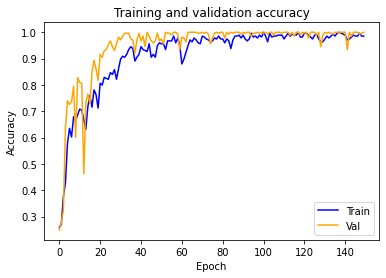

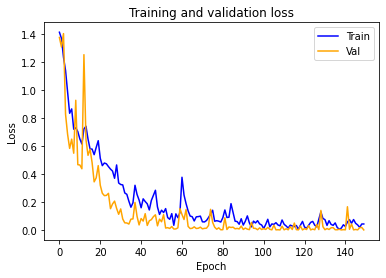

In [ ]:
# Plot the training and validation accuracy
plot(history)

After the 60th epoch, the training and validation curve both becomes stable. However, we can observe that the validation loss and accuracy have some drastic fluctuation during the training epochs. This may caused by the small amount of data in the validation set. Regardless of the fluctuation, the accuracy of validation set finally reaches close to 1, much higher than our first model without data augmentation. Therefore data augmentation has improved the performance of our model from scratch. The reason that validation accuracy reaches near 1 is because images of different classes is distinctive so that given enough amount of data (by data augmentation), a fairly complex model would successfully classify those classes.

In [ ]:
# Training can be stopped after the 59th epoch,
# since there is no significant improvement of the validation performance.
model.load_weights(pathlib.Path(str(checkpoint_filepath) + '/model.59.h5'))

In [ ]:
# evaluate on the validation data to get loss and accuracy
model.evaluate(validation_generator)

9/9 [==============================] - 6s 658ms/step - loss: 0.0154 - accuracy: 0.9927


[0.015407618135213852, 0.9926739931106567]

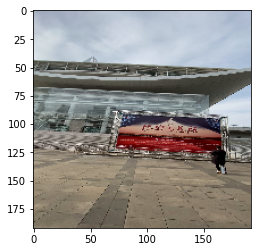

Prediction theater
Actual theater


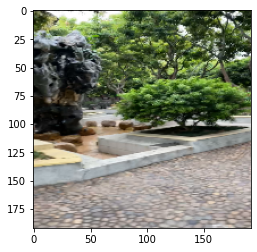

Prediction stone
Actual stone


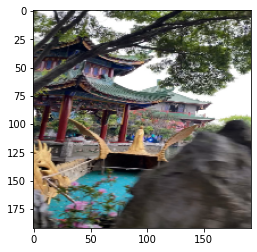

Prediction pavilion
Actual pavilion


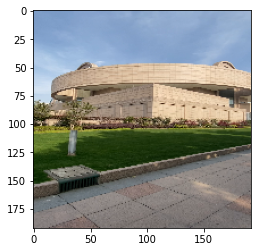

Prediction museum
Actual museum


In [ ]:
# Show one prediction for each class
for class_path in list(pathlib.Path('/content/testing_data').glob('*')):
    label = os.path.basename(class_path)
    for image_path in list(class_path.glob('*')):
        img = load_and_preprocess_image(str(image_path)) # read and preprocess the image
        batch_pred = model.predict(tf.expand_dims(img, axis=0)) # return prediction of batch size 1
        pred = batch_pred[0]
        plt.imshow(img) # plot the image
        plt.show()
        print("Prediction", label_names[tf.argmax(pred)])
        print("Actual", label)
        break

## V. Export the model and run it in the browser

In [ ]:
# save the model 
model.save("/content/my_model.h5")

In [ ]:
from google.colab import files
files.download("/content/my_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Run the model in the browser. We have to modify the original index.js file. The Class configuration is changed to 
CLASSES = {
  0: 'museum',
  1: 'pavilion',
  2: 'stone',
  3: 'theater',
};
and TOPK_PREDICTIONS = 4;
We did not change other configurations in the index.js because the data preprocessing method is the same as the first part- converting the size to 192*192 and normalize the value to 0-1 by dividing by 255.
We use a picture from 'pavilion' class as default picture. 
In the screenshot below, a picture of theater is uploaded to the brower and a prediction is made, showing a high confidence of the picture belonging to the 'theater' class.

Also, I have created a github page repo of the model which can be visited https://xuan-he-97.github.io/index.html . You can download data from shared google drive file https://drive.google.com/file/d/1rj-RaymLVMJoZOrkxa2wt0h2-EoPrDVL/view?usp=sharing and upload an image to the browser to make prediction of its class. 

![alt text](https://user-images.githubusercontent.com/79208856/112728911-807b5500-8f64-11eb-8dc0-a107eec360ba.png)